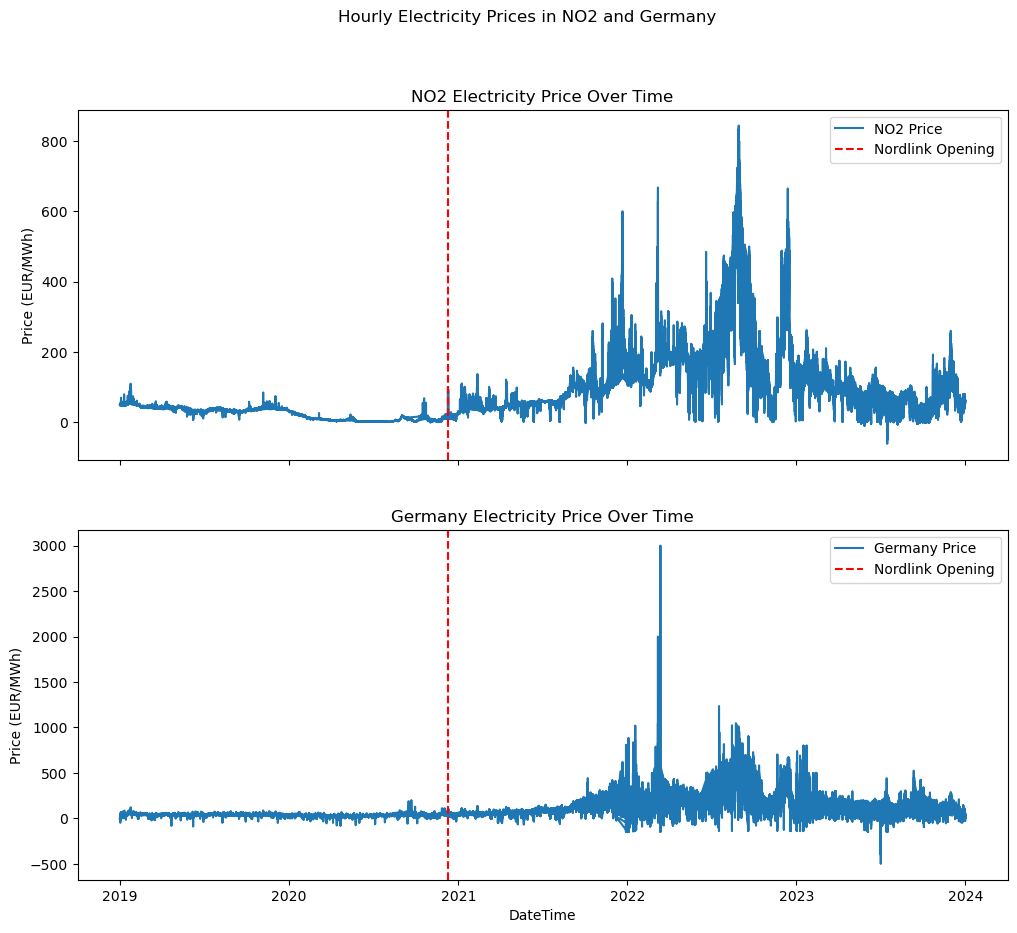

In [17]:
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt

# Define the data path
data_path = "C:/Users/Einar/TECH2/DATA/data/data"  # Use raw string to handle Windows backslashes

# Load electricity prices dataset with tab delimiter
price_files = glob(os.path.join(data_path, 'DayAheadPrices_12.1.D', '*.csv'))
prices = pd.concat([pd.read_csv(file, delimiter='\t') for file in price_files], ignore_index=True)

# Load physical flows dataset with tab delimiter
flow_files = glob(os.path.join(data_path, 'PhysicalFlows_12.1.G', '*.csv'))
flows = pd.concat([pd.read_csv(file, delimiter='\t') for file in flow_files], ignore_index=True)

# Convert 'DateTime' to datetime in the prices data
prices['DateTime'] = pd.to_datetime(prices['DateTime'])

# Filter for NO2 and DE_LU regions
prices_no2 = prices[prices['MapCode'] == 'NO2']
prices_de = prices[prices['MapCode'] == 'DE_LU']

# Define the date of Nordlink's opening for reference in the plot
nordlink_opening = pd.to_datetime('2020-12-09')

# Create subplots for Task 1 visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Hourly Electricity Prices in NO2 and Germany')

# NO2 Price Plot
ax1.plot(prices_no2['DateTime'], prices_no2['Price'], label='NO2 Price')
ax1.axvline(nordlink_opening, color='r', linestyle='--', label='Nordlink Opening')
ax1.set_title('NO2 Electricity Price Over Time')
ax1.set_ylabel('Price (EUR/MWh)')
ax1.legend()

# DE_LU (Germany) Price Plot
ax2.plot(prices_de['DateTime'], prices_de['Price'], label='Germany Price')
ax2.axvline(nordlink_opening, color='r', linestyle='--', label='Nordlink Opening')
ax2.set_title('Germany Electricity Price Over Time')
ax2.set_ylabel('Price (EUR/MWh)')
ax2.set_xlabel('DateTime')
ax2.legend()

# Save the figure
plt.savefig('figure_task1.png')  # Saved locally in the current directory
plt.show()


In [18]:
import pandas as pd

# Ensure 'DateTime' is in datetime format and add a 'Year' column for grouping
prices['DateTime'] = pd.to_datetime(prices['DateTime'])
prices['Year'] = prices['DateTime'].dt.year

# Filter for NO2 and DE_LU regions
prices_no2 = prices[prices['MapCode'] == 'NO2']
prices_de = prices[prices['MapCode'] == 'DE_LU']

# Define a function to calculate descriptive statistics
def descriptive_stats(df):
    return df.agg(['mean', 'median', 'std', 'min', 'max']).round(2)

# Calculate statistics for each year for NO2
no2_stats = prices_no2.groupby('Year')['Price'].apply(descriptive_stats).unstack()

# Calculate statistics for each year for DE_LU
de_stats = prices_de.groupby('Year')['Price'].apply(descriptive_stats).unstack()

# Combine the two DataFrames for easier comparison
combined_stats = pd.concat([no2_stats, de_stats], axis=1, keys=['NO2', 'DE_LU'])

# Save the results to an Excel file
combined_stats.to_excel('table_task2.xlsx')

combined_stats


NO2                                  DE_LU                          \
        mean  median     std    min     max    mean  median     std     min   
Year                                                                          
2019   39.26   38.81    8.23   5.86  109.45   37.67   38.06   15.52  -90.01   
2020    9.29    6.95    8.26  -1.73   99.92   30.47   30.99   17.50  -83.94   
2021   75.11   59.34   47.22  -1.97  600.16  130.41   90.44  104.80 -149.99   
2022  211.28  181.13  125.85   0.04  844.00  237.10  208.54  148.24 -149.99   
2023   79.44   80.46   36.28 -61.84  261.85   95.07   95.90   59.16 -500.00   

               
          max  
Year           
2019   121.46  
2020   200.04  
2021   809.50  
2022  2999.99  
2023   800.00

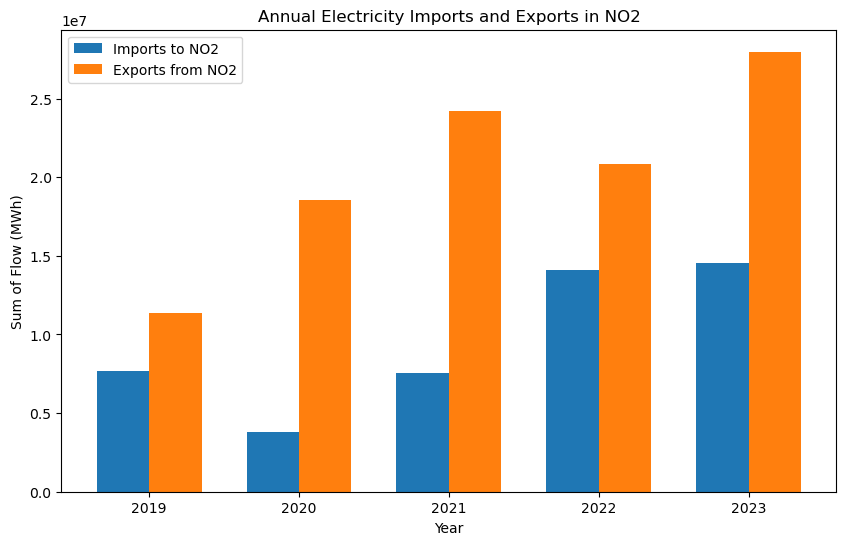

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'DateTime' is in datetime format and add a 'Year' column
flows['DateTime'] = pd.to_datetime(flows['DateTime'])
flows['Year'] = flows['DateTime'].dt.year

# Filter data for imports to and exports from NO2
imports_to_no2 = flows[flows['InMapCode'] == 'NO2']
exports_from_no2 = flows[flows['OutMapCode'] == 'NO2']

# Calculate annual sums of imports and exports
annual_imports = imports_to_no2.groupby('Year')['FlowValue'].sum()
annual_exports = exports_from_no2.groupby('Year')['FlowValue'].sum()

# Create a single bar plot
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35  # Width of the bars

# Plot imports and exports side by side for each year
ax.bar(annual_imports.index - width/2, annual_imports, width=width, label='Imports to NO2')
ax.bar(annual_exports.index + width/2, annual_exports, width=width, label='Exports from NO2')

# Labels and title
ax.set_title('Annual Electricity Imports and Exports in NO2')
ax.set_xlabel('Year')
ax.set_ylabel('Sum of Flow (MWh)')
ax.legend()

# Save the figure
plt.savefig('figure_task3.png')
plt.show()


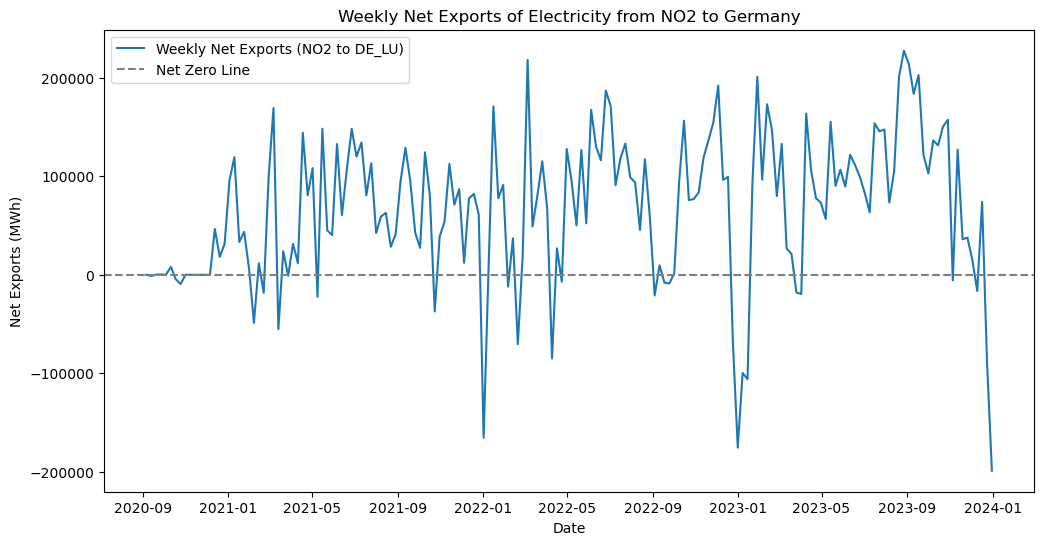

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'DateTime' is in datetime format
flows['DateTime'] = pd.to_datetime(flows['DateTime'])

# Filter exports from NO2 to DE_LU and imports to NO2 from DE_LU
exports_from_no2_to_de = flows[(flows['OutMapCode'] == 'NO2') & (flows['InMapCode'] == 'DE_LU')]
imports_to_no2_from_de = flows[(flows['InMapCode'] == 'NO2') & (flows['OutMapCode'] == 'DE_LU')]

# Set 'DateTime' as the index for easier resampling
exports_from_no2_to_de.set_index('DateTime', inplace=True)
imports_to_no2_from_de.set_index('DateTime', inplace=True)

# Resample to weekly sums
weekly_exports = exports_from_no2_to_de['FlowValue'].resample('W').sum()
weekly_imports = imports_to_no2_from_de['FlowValue'].resample('W').sum()

# Calculate weekly net exports (exports - imports)
weekly_net_exports = weekly_exports - weekly_imports

# Create the line plot for weekly net exports
plt.figure(figsize=(12, 6))
plt.plot(weekly_net_exports.index, weekly_net_exports, label='Weekly Net Exports (NO2 to DE_LU)')
plt.axhline(0, color='gray', linestyle='--', label='Net Zero Line')
plt.title('Weekly Net Exports of Electricity from NO2 to Germany')
plt.xlabel('Date')
plt.ylabel('Net Exports (MWh)')
plt.legend()

# Save the figure
plt.savefig('figure_task4.png')
plt.show()


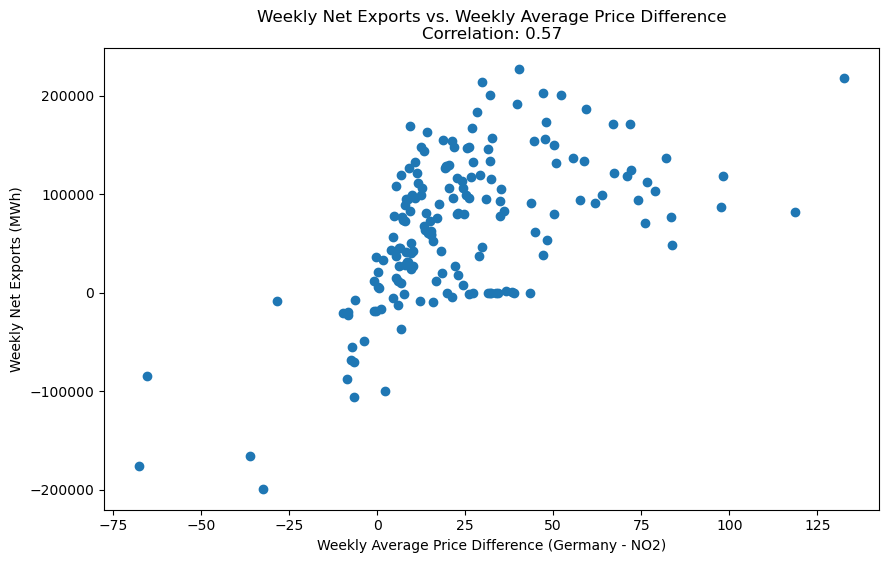

In [23]:
# Align the indices of weekly_avg_price_diff and weekly_net_exports to ensure they match
aligned_data = pd.DataFrame({
    'WeeklyAvgPriceDiff': weekly_avg_price_diff,
    'WeeklyNetExports': weekly_net_exports
}).dropna()  # Drop any rows with NaN values

# Extract the aligned series for plotting
aligned_price_diff = aligned_data['WeeklyAvgPriceDiff']
aligned_net_exports = aligned_data['WeeklyNetExports']

# Calculate the correlation coefficient
correlation = aligned_net_exports.corr(aligned_price_diff)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(aligned_price_diff, aligned_net_exports)
plt.title(f'Weekly Net Exports vs. Weekly Average Price Difference\nCorrelation: {correlation:.2f}')
plt.xlabel('Weekly Average Price Difference (Germany - NO2)')
plt.ylabel('Weekly Net Exports (MWh)')

# Save the figure
plt.savefig('figure_task5.png')
plt.show()

